In [76]:
import os
import h5py

#DATA_FOLDER = "/Users/mduranfrigola/Downloads/"
DATA_FOLDER = "/path/to/data/" # this folder needs to contain the fid2smi_std_grover_embedding.h5 file. Please reach out to miquel@ersilia.io if you need this file.

def fragment_embeddings(filter=None):
    with h5py.File(
        os.path.join(DATA_FOLDER, "fid2smi_std_grover_embedding.h5"),
        "r",
    ) as f:
        X = f["Values"][:]
        fids = [x.decode("utf-8") for x in f["Keys"][:]]
    if filter is None:
        return X, fids
    else:
        filt = set(filter["fid"])
        fids_ = []
        idxs_ = []
        for i, fid in enumerate(fids):
            if fid in filt:
                idxs_ += [i]
                fids_ += [fid]
        return X[idxs_], fids_

In [1]:
X, fids = fragment_embeddings()

In [46]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler

reducer = UMAP(
    densmap=True,
    n_neighbors=15,
    metric="euclidean",
    low_memory=False,
    repulsion_strength=3,
    negative_sample_rate=50,
    verbose=True,
)

In [47]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
reducer.fit(X)

UMAP(densmap=True, low_memory=False, negative_sample_rate=50, repulsion_strength=3, verbose=True)
Wed Apr 19 00:41:59 2023 Construct fuzzy simplicial set
Wed Apr 19 00:41:59 2023 Finding Nearest Neighbors
Wed Apr 19 00:41:59 2023 Building RP forest with 13 trees
Wed Apr 19 00:42:01 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Wed Apr 19 00:42:06 2023 Finished Nearest Neighbor Search
Wed Apr 19 00:42:07 2023 Construct embedding
Wed Apr 19 00:42:08 2023 Computing original densities


Epochs completed: 100%| ██████████ 400/400 [00:37]


Wed Apr 19 00:42:51 2023 Finished embedding


UMAP(densmap=True, low_memory=False, negative_sample_rate=50, repulsion_strength=3, verbose=True)

In [48]:
Xt = reducer.transform(X)

In [59]:
import csv
import collections

myfids = set(pd.read_csv("../data/screening.tsv", sep="\t")["FragID"])

libraries = collections.defaultdict(set)
with open(os.path.join(DATA_FOLDER, "fid2lib.tsv"), "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        if r[1] == "CeMM Functionalized":
            continue
        if r[1] == "CeMM Non-Functionalized":
            if r[0].split("-")[0] not in myfids:
                continue
        if r[1] == "Enamine Fully Functionalized":
            continue
        libraries[r[1]].update([r[0]])

In [78]:
from stylia import ContinuousColorMap
cmap = ContinuousColorMap()
cmap.fit([i for i in range(12)])
colors = cmap.transform([i for i in range(12)])

library_idxs = dict((k, i) for i, k in enumerate(libraries.keys()))

def chemical_space_plot(ax, library):
    ax.scatter(Xt[:, 0], Xt[:, 1], s=0.5, color=NamedColors().gray, alpha=0.1)
    idxs = [i for i, fid in enumerate(fids) if fid in libraries[library]]
    ax.scatter(Xt[idxs, 0], Xt[idxs, 1], s=0.5, color=colors[library_idxs[library]])
    ax.set_title(library)
    ax.set_axis_off()
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 60)

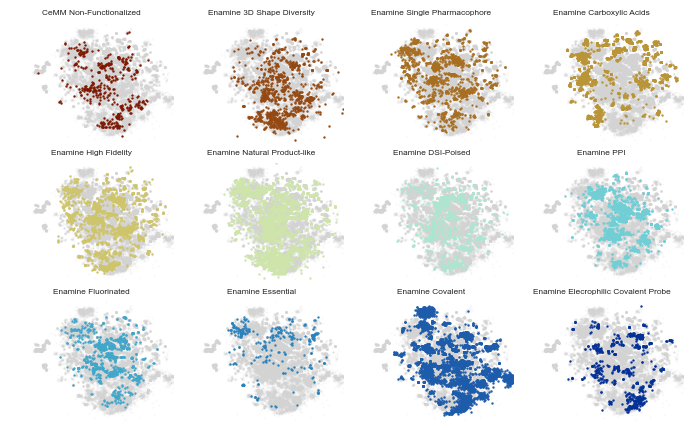

In [80]:
import stylia
from stylia import TWO_COLUMNS_WIDTH

from stylia import ContinuousColorMap



fig, axs = stylia.create_figure(3, 4, width=TWO_COLUMNS_WIDTH*0.97, height=TWO_COLUMNS_WIDTH*0.6)
for k, v in libraries.items():
    ax = axs.next()
    chemical_space_plot(ax, k)

plt.tight_layout()
stylia.save_figure("../assets/chemical-spaces-others.png")
stylia.save_figure("../assets/chemical-spaces-others.pdf")

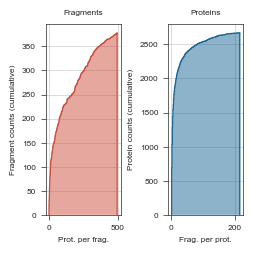

In [81]:

import pandas as pd
import collections
import matplotlib.pyplot as plt
import stylia
from stylia import TWO_COLUMNS_WIDTH, NamedColors

db = pd.read_csv("../results/Table-S2.csv")
pxfc = collections.defaultdict(int)
fxpc = collections.defaultdict(int)
for r in db[["accession", "fragId"]].values:
    pxfc[r[1]] += 1
    fxpc[r[0]] += 1

pxfc = [(k,v) for k,v in pxfc.items()]
fxpc = [(k,v) for k,v in fxpc.items()]

fig, axs = stylia.create_figure(1,2, width=TWO_COLUMNS_WIDTH*0.35, height=TWO_COLUMNS_WIDTH*0.35)

ax = axs.next()
ax.hist(
    [x[1] for x in pxfc],
    10000,
    cumulative=True,
    histtype="stepfilled",
    color=NamedColors().red,
    alpha=0.5,
)
ax.hist(
    [x[1] for x in pxfc], 10000, cumulative=True, histtype="step", color=NamedColors().red
)
ax.set_xlabel("Prot. per frag.")
ax.set_ylabel("Fragment counts (cumulative)")
ax.set_title("Fragments")
ax = axs.next()
ax.hist(
    [x[1] for x in fxpc],
    10000,
    cumulative=True,
    histtype="stepfilled",
    color=NamedColors().blue,
    alpha=0.5,
)
ax.hist(
    [x[1] for x in fxpc], 10000, cumulative=True, histtype="step", color=NamedColors().blue
)
ax.set_xlabel("Frag. per prot.")
ax.set_ylabel("Protein counts (cumulative)")
ax.set_title("Proteins")

plt.tight_layout()
plt.savefig("../assets/specificy-cumulative.png", dpi=300)
plt.savefig("../assets/specificy-cumulative.pdf")

In [26]:
import pandas as pd
import csv
import collections

df = pd.read_csv("../data/finalScreen.tsv", sep="\t")
df = df[df["nUniq"] >= 2]
db = df[df["l2fc"] >= 2.3]
db = db[db["l2fcM"] >= 1]
db = db[db["ml10p"] > -np.log10(0.05)]
db = db[db["ml10adjP"] > -np.log10(2.5)]
db = db[db["rankRel"] < 500]

bdprots = set(db["accession"])

In [42]:
tclin = set()
tchem = set()

with open("../data/annotations/pharos_protein_category.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        if r[1] == "Tclin":
            tclin.update([r[0]])
            tchem.update([r[0]])
        if r[1] == "Tchem":
            tchem.update([r[0]])

def read_annotations(name):
    data = collections.defaultdict(set)
    with open("../data/annotations/{0}.tsv".format(name), "r") as f:
        reader = csv.reader(f, delimiter="\t")
        for r in reader:
            data[r[1]].update([r[0]])
    return data
 
data = read_annotations("panther_protein_class")
data = dict((k, v) for k,v in data.items() if len(v) >= 30)
sorted_keys = [x[0] for x in sorted(data.items(), key=lambda x: -len(x[1]))]

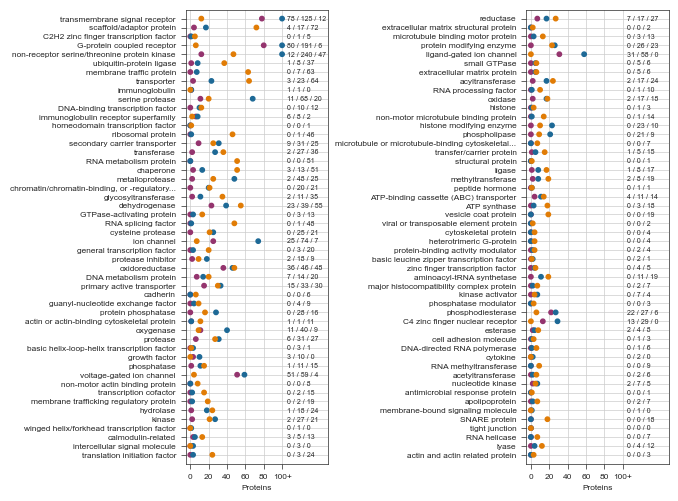

In [78]:
import numpy as np
import textwrap

def ranking_plot(ax, terms):
    colors = [NamedColors().purple, NamedColors().blue, NamedColors().orange]
    for i, t in enumerate(terms):
        a = len(data[t].intersection(tclin))
        b = len(data[t].intersection(tchem))
        c = len(data[t].intersection(bdprots))
        ax.scatter(np.clip([a, b, c], 0, 100), [i]*3, color=colors)
        ax.text(105, i, "{0} / {1} / {2}".format(a, b, c), va="center", ha="left")
    ax.set_yticks([i for i in range(len(terms))])
    ax.set_yticklabels([textwrap.shorten(x, width=50, placeholder="...") for x in terms])
    ax.set_xticks([0, 20, 40, 60, 80, 100])
    ax.set_xticklabels(["0", "20", "40", "60", "80", "100+"])
    ax.set_ylim(len(terms), -1)
    ax.set_xlim(-5, 150)
    stylia.label(ax, title="", ylabel="", xlabel="Proteins")

fig, axs = stylia.create_figure(1,2, width=TWO_COLUMNS_WIDTH*0.95, height=TWO_COLUMNS_WIDTH*0.7)
ax = axs.next()
ranking_plot(ax, sorted_keys[:50])
ax = axs.next()
ranking_plot(ax, sorted_keys[50:])
plt.tight_layout()

stylia.save_figure("../assets/panther_protein_coverage.png")
stylia.save_figure("../assets/panther_protein_coverage.pdf")

In [10]:
import pandas as pd
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
from stylia import TWO_COLUMNS_WIDTH
import stylia
from stylia import NamedColors

tested = ["V0049", "V0157", "V0081", "V0480", "V0302", "V0053", "V4856", "V0005", "V5335", "V5151", "V0019", "V0022"]

dv = pd.read_csv("../data/validation.tsv", sep="\t")
dv = dv[dv["FragID"].isin(tested)]
df = dv.copy()
dv = dv[dv["Number_of_Protein_Unique_Peptides"] >= 2]
dv = dv[dv["Abundance_Ratio_PValue"] < 0.05]
dv = dv[dv["Abundance_Ratio_Adj_PValue"] < 0.25]
dv = dv[dv["Abundance_Ratio_log2"] > 2.3]
dv = dv[dv["Abundance_Ratio_log2_median_corr"] > 1]
dv = dv[dv["Rank_relative"] < 500]

In [11]:
def volcano(ax, fid, color):
    x = np.array(df[df["FragID"] == fid]["Abundance_Ratio_log2"])
    y = -np.log10(np.array(df[df["FragID"] == fid]["Abundance_Ratio_PValue"]))
    ax.scatter(x,y, color=NamedColors().gray, s=1, alpha=0.5)
    x = np.array(dv[dv["FragID"] == fid]["Abundance_Ratio_log2"])
    y = -np.log10(np.array(dv[dv["FragID"] == fid]["Abundance_Ratio_PValue"]))
    ax.scatter(x,y, color=color, s=2)

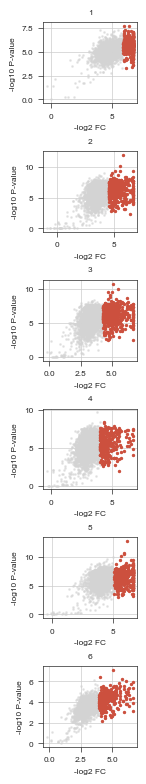

In [12]:
fig, axs = stylia.create_figure(6,1, width=TWO_COLUMNS_WIDTH*0.2, height=TWO_COLUMNS_WIDTH*1.1)
for i, fid in enumerate(tested[:6]):
    ax = axs.next()
    volcano(ax, fid, NamedColors().red)
    stylia.label(ax, title=i+1, ylabel = "-log10 P-value", xlabel = "-log2 FC")

plt.tight_layout()
stylia.save_figure("../assets/promiscuity-volcano-promiscuous.png")
stylia.save_figure("../assets/promiscuity-volcano-promiscuous.pdf")

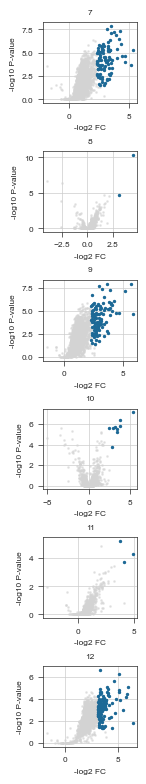

In [13]:
fig, axs = stylia.create_figure(6,1, width=TWO_COLUMNS_WIDTH*0.2, height=TWO_COLUMNS_WIDTH*1.1)
for i, fid in enumerate(tested[6:]):
    ax = axs.next()
    volcano(ax, fid, NamedColors().blue)
    stylia.label(ax, title=7+i, ylabel = "-log10 P-value", xlabel = "-log2 FC")

plt.tight_layout()
stylia.save_figure("../assets/promiscuity-volcano-non-promiscuous.png")
stylia.save_figure("../assets/promiscuity-volcano-non-promiscuous.pdf")